# FDS Kaggle Competition: Pokémon Battle Prediction

**Objective:** This notebook documents the development of a binary classification model to predict the winner of a Pokémon battle using only the data from the first
30 turns (for all details, please refer to [FDS Kaggle Competition Pokémon Battles Prediction](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025))

## Approaches

For this project, we considered two different approaches.

---

### First Approach: Non-Sequential Modeling

In the **first approach**, we ignored the sequential nature of the battles. Instead of considering the turn-by-turn evolution, we treated each battle as an independent instance. Using various aggregation functions over the 30 turns, we constructed a single representative record for each battle, capturing overall statistics such as average damage, total HP difference, and key move frequencies. This aggregated representation was then used with traditional machine learning models to predict the final outcome of the battle.

---

### Second Approach: Sequential Modeling

In the **second approach**, we explicitly modeled each battle as a sequence of turns rather than a single static snapshot. Every battle contains up to 30 turns, so we extracted a feature vector at every turn, capturing static team information, HP levels, fainted counts, statuses, boosts, and other dynamic combat signals. This produced a fixed-length sequence representation for each battle, with padding applied to shorter matches.

We then trained LSTM and GRU models to learn temporal patterns across turns. To determine the best architecture, we performed a 5-fold cross-validation hyperparameter search, tuning the learning rate, hidden size, bidirectionality, number of recurrent layers, dropout rate, fully connected layer size, and number of training epochs. Each configuration was evaluated using mean validation loss curves, and the best settings were selected accordingly.



### 1. Setup & Data Loading

#### 1.1. Import Libraries

In [ ]:
from constants import *

#### 1.2. Kaggle Setup & Data Download

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
print("Logging into Kaggle...")
kagglehub.login()

In [ ]:
print("\nDownloading competition data...")
# This helper function finds the path to the competition data
fds_pokemon_battles_prediction_2025_path = kagglehub.competition_download('fds-pokemon-battles-prediction-2025')
print('Data source import complete.')

# --- Define the path to our data ---
DATA_PATH = fds_pokemon_battles_prediction_2025_path
print(f"Data path set to: {DATA_PATH}")

100%|██████████| 10.4M/10.4M [00:01<00:00, 6.60MB/s]

Extracting files...


Data source import complete.
Data path set to: /root/.cache/kagglehub/competitions/fds-pokemon-battles-prediction-2025


### 1.3. Load JSONL Data

We read each file line-by-line and store the data in two lists: `train_data` and `test_data`.

In [ ]:
from utils.data import load_jsonl_data

# --- Load Training Data ---
train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
train_data = load_jsonl_data(train_file_path)

# --- Load Testing Data ---
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
test_data = load_jsonl_data(test_file_path)

Successfully loaded 10000 records from '/root/.cache/kagglehub/competitions/fds-pokemon-battles-prediction-2025/train.jsonl'.
Successfully loaded 5000 records from '/root/.cache/kagglehub/competitions/fds-pokemon-battles-prediction-2025/test.jsonl'.


### 2. Exploratory Data Analysis (EDA) & Domain Mapping

#### 2.1. First Look: The Anatomy of a Battle

We inspect the first record from our training data (`train_data[0]`) to understand its nested keys and complex structure

In [ ]:
print(json.dumps(train_data[0], indent=2))

{
  "player_won": true,
  "p1_team_details": [
    {
      "name": "starmie",
      "level": 100,
      "types": [
        "psychic",
        "water"
      ],
      "base_hp": 60,
      "base_atk": 75,
      "base_def": 85,
      "base_spa": 100,
      "base_spd": 100,
      "base_spe": 115
    },
    {
      "name": "exeggutor",
      "level": 100,
      "types": [
        "grass",
        "psychic"
      ],
      "base_hp": 95,
      "base_atk": 95,
      "base_def": 85,
      "base_spa": 125,
      "base_spd": 125,
      "base_spe": 55
    },
    {
      "name": "chansey",
      "level": 100,
      "types": [
        "normal",
        "notype"
      ],
      "base_hp": 250,
      "base_atk": 5,
      "base_def": 5,
      "base_spa": 105,
      "base_spd": 105,
      "base_spe": 50
    },
    {
      "name": "snorlax",
      "level": 100,
      "types": [
        "normal",
        "notype"
      ],
      "base_hp": 160,
      "base_atk": 110,
      "base_def": 65,
      "base_spa": 6

#### 2.2. Data Structure Overview

Our first look at `train_data[0]` reveals that each battle is a complex JSON object with several root keys. The **root-level keys** for each battle object are::

* `"player_won"`: Our boolean target variable.
* `"battle_id"`: A unique identifier for the battle.
* `"p1_team_details"`: A **list of 6** dictionaries, one for each Pokémon on Player 1's team. This includes their full base stats (e.g., `base_hp`, `base_atk`).
* `"p2_lead_details"`: A **single dictionary** describing only Player 2's *lead* Pokémon. This also includes its base stats.
* `"battle_timeline"`: A list of dictionaries, one for each turn (up to 30), detailing the in-battle state, moves used, and active Pokémon for both players.

This structure shows we have full team information for Player 1, but only partial "Turn 0" information for Player 2.

#### 2.3. Full Data Scan & Knowledge Base Creation

To understand the full scope of the data, we will perform one comprehensive pass over the entire `train_data`.

The goals of this scan are:
1.  **Discover all unique game elements**: Find every unique status (e.g., 'brn', 'par'), effect, move, etc. This is essential for creating a complete Data Dictionary.
2.  **Build a Pokémon Database (`pokemon_db`)**: As a useful new representation of the data, we will store the base stats for every Pokémon species we encounter. This will allow us to look up stats for any Pokémon seen in the timeline, not just P1's team or P2's lead.

In [ ]:
from utils.pokemon import build_knowledge_base, print_universe_summary

pokemon_db, unique_game_elements = build_knowledge_base(train_data)
print_universe_summary(pokemon_db, unique_game_elements)


Scanning all 10,000 training battles to build Knowledge Base...


Mapping Game Universe (Train):   0%|          | 0/10000 [00:00<?, ?it/s]


--- Universe Mapped (from Training Data) ---

Registered 20 unique Pokémon species in Knowledge Base:
   ['alakazam', 'articuno', 'chansey', 'charizard', 'cloyster', 'dragonite', 'exeggutor', 'gengar', 'golem', 'jolteon', 'jynx', 'lapras', 'persian', 'rhydon', 'slowbro', 'snorlax', 'starmie', 'tauros', 'victreebel', 'zapdos']

Game Elements Discovered:
 - Statuses (8):
   ['brn', 'fnt', 'frz', 'nostatus', 'par', 'psn', 'slp', 'tox']
 - Effects (8):
   ['clamp', 'confusion', 'firespin', 'noeffect', 'reflect', 'substitute', 'typechange', 'wrap']
 - Move Categories (3):
   ['PHYSICAL', 'SPECIAL', 'STATUS']
 - Move Types (13):
   ['ELECTRIC', 'FIGHTING', 'FIRE', 'FLYING', 'GHOST', 'GRASS', 'GROUND', 'ICE', 'NORMAL', 'POISON', 'PSYCHIC', 'ROCK', 'WATER']
 - Move Names (40):
   ['agility', 'amnesia', 'blizzard', 'bodyslam', 'clamp', 'confuseray', 'counter', 'doubleedge', 'doublekick', 'drillpeck', 'earthquake', 'explosion', 'fireblast', 'firespin', 'hyperbeam', 'hypnosis', 'icebeam', 'lovel

#### 2.4. The Data Dictionary

We can now define our official **Data Dictionary**. This documents the key data fields discovered.

---

#### **Root Level Keys**

* `"player_won"`: Our **target variable**. Boolean (`true`/`false`).
* `"battle_id"`: The unique **identifier** for the battle.
* `"p1_team_details"`: A list of 6 dictionaries (one for each Pokémon) containing their static details. (See `Pokémon Details` below).
* `"p2_lead_details"`: A single dictionary for P2's lead Pokémon. (See `Pokémon Details` below).
* `"battle_timeline"`: A list of turn objects (up to 30), representing the battle's progression.

---

#### **Level 2: Pokémon Details (Static)**
*(Found within `p1_team_details` and `p2_lead_details`)*

Describes a Pokémon's intrinsic properties.

* `"name"`: The species name (e.g., `'alakazam'`, `'snorlax'`).
* `"level"`: The Pokémon's level (always `100`).
* `"types"`: A list of elemental types (e.g., `['grass', 'psychic']`).
* **Base Stats:**
    * `"base_hp"`: Base Hit Points (durability).
    * `"base_atk"`: Base Attack (for Physical moves).
    * `"base_def"`: Base Defense (against Physical moves).
    * `"base_spa"`: Base Special Attack (for Special moves).
    * `"base_spd"`: Base Special Defense (against Special moves).
    * `"base_spe"`: Base Speed (determines action order).

---

#### **Level 2: Pokémon State (Dynamic)**
*(Found within `battle_timeline` as `pX_pokemon_state`)*

Details the active Pokémon's state at the end of a turn.

* `"name"`: The name of the Pokémon on the field.
* `"hp_pct"`: Current HP Percentage (Float, 0.0 to 1.0).
* `"status"`: The main non-volatile status condition.
    * **Unique Values:** `['brn', 'fnt', 'frz', 'nostatus', 'par', 'psn', 'slp', 'tox']`
    * **Interpretation:** `fnt` (Faint), `brn` (Burn), `par` (Paralysis), `slp` (Sleep), etc.
* `"boosts"`: Temporary stat multipliers for `atk`, `def`, `spa`, `spd`, `spe`. (Integer, -6 to +6).
* `"effects"`: Volatile battle effects.
    * **Unique Values:** `['clamp', 'confusion', 'firespin', 'noeffect', 'reflect', 'substitute', 'typechange', 'wrap']`

---

#### **Level 2: Move Details (Dynamic)**
*(Found within `battle_timeline` as `pX_move_details`)*

Details the move selected in that turn (`null` if none).

* `"name"`: The name of the move used.
    * **Unique Values (40 total):** `['agility', 'amnesia', 'blizzard', 'bodyslam', ... , 'thunderwave', 'toxic', 'wrap']`
* `"category"`: The move's category.
    * **Unique Values:** `['PHYSICAL', 'SPECIAL', 'STATUS']`
    * **Interpretation:** Determines damage calculation (Physical/Special) or no damage (Status).
* `"type"`: The move's elemental type.
    * **Unique Values (13 total):** `['ELECTRIC', 'FIGHTING', 'FIRE', ... , 'ROCK', 'WATER']`
* `"base_power"`: The move's base power (Integer). 0 for Status moves.
* `"accuracy"`: The move's chance to hit (Float, 0.0-1.0).
* `"priority"`: Determines move order independent of Speed (Integer, usually 0).

## First Approach

### 3. Methodology & Reusable Components

This section defines the core reusable functions for our pipeline, ensuring consistency across all experiments.

1.  **Validation Strategies:** Standardized functions for model evaluation.
2.  **Feature Extraction Helpers:** Modular functions to extract specific information groups.
3.  **Main Feature Creation Pipeline:** The central orchestrator that builds the final feature set for any given iteration.

#### 3.1. Validation Strategies

We define two validation methods:
1.  `run_simple_validation`: A basic 90/10 `train_test_split`.
2.  `run_kfold_validation`: A robust 5-Fold Cross-Validation. This is our "gold standard" for final model evaluation.

In [ ]:
from utils.singular.validation import (
    run_simple_validation,
    run_kfold_validation,
    init_results_store,
    store_result,
)
results = init_results_store()

print("Defined validation functions: 'run_simple_validation' and 'run_kfold_validation'.")
print("Initialized 'results' dictionary to store scores.")

Defined validation functions: 'run_simple_validation' and 'run_kfold_validation'.
Initialized 'results' dictionary to store scores.


## 3.2. Feature Extraction Helpers

These are our modular "helper" functions. Each function is responsible for one logical task (e.g., extracting only the static "Turn 0" stats).

For Iteration 1, we only need to define the helper that extracts our static (Turn 0) features.

In [ ]:
from utils.singular.feature import *
print("Defined all v1, v2, and v3 (REFINED) feature extraction helper functions.")


Defined all v1, v2, and v3 (REFINED) feature extraction helper functions.


## 3.3. Main Feature Creation Pipeline

This is the main function that builds our features. It calls the correct helper functions (from 3.2) based on an `iteration_name`.

This centralized approach ensures that the raw data is processed consistently and efficiently for each experiment.

In [ ]:
from utils.singular.feature import create_features

Defined main 'create_features' pipeline function (v1, v2, v3 enabled).


# 4. Iteration 1: Baseline (Static Snapshot @ Turn 0)

**Objective:** Establish our initial baseline score.

**Features (v1):** 12 features.
* P1: Mean stats of all 6 team members (6 stats).
* P2: Base stats of the *single lead* Pokémon (6 stats).

**Validation:** Simple 90/10 Split (using our `run_simple_validation` function).

In [ ]:
# 1. Create v1 features
X_v1, y_v1 = create_features(train_data, pokemon_db, "v1")

# 2. Run v1 validation
results['v1_simple_split'] = run_simple_validation(
    X_v1,
    y_v1,
    model_class=LogisticRegression, # Using Logistic Regression as our baseline model
    max_iter=1000
)

print(f"\nIteration 1 Baseline Accuracy: {results['v1_simple_split']:.4f}")


--- Creating features for 'v1' --- 


Processing 'v1' features:   0%|          | 0/10000 [00:00<?, ?it/s]

Successfully created feature set with 12 features.

--- Running Simple Validation (90/10 Split) ---
Model: LogisticRegression
Validation Accuracy: 0.5430
--------------------------------------------

Iteration 1 Baseline Accuracy: 0.5430


# 5. Iteration 2: Key Dynamics (Snapshot @ Turn 30)

**Objective:** Measure the impact of adding key "Turn 30 Snapshot" features.

**Features (v2):** 19 features total.

* **(v1)** All 12 static features from Iteration 1.
* **New** 7 new dynamic features:
  * `p1_fainted_count`, `p2_fainted_count`, `fainted_advantage`
  * `p1_total_hp_pct`, `p2_total_hp_pct_estimated`, `hp_advantage`
  * `p2_unseen_count`

**Hypothesis:** Knowing how many Pokémon have fainted should be highly predictive.

**Validation:** Simple 90/10 Split (to compare directly with Iteration 1).

In [ ]:
# 1. Create v2 features
X_v2, y_v2 = create_features(train_data, pokemon_db, "v2")

# 2. Run v2 validation (using the same model as v1 for a fair comparison)
results['v2_simple_split'] = run_simple_validation(
    X_v2,
    y_v2,
    model_class=LogisticRegression,
    max_iter=1000
)

# 3. Analyze the improvement
improvement = results['v2_simple_split'] - results['v1_simple_split']
print(f"\nIteration 2 Accuracy: {results['v2_simple_split']:.4f}")
print(f"Improvement from v1:  {improvement:+.4f}")


--- Creating features for 'v2' --- 


Processing 'v2' features:   0%|          | 0/10000 [00:00<?, ?it/s]

Successfully created feature set with 19 features.

--- Running Simple Validation (90/10 Split) ---
Model: LogisticRegression
Validation Accuracy: 0.8420
--------------------------------------------

Iteration 2 Accuracy: 0.8420
Improvement from v1:  +0.2990


# 6. Iteration 3: Refinement (Granular Status & Boosts)

**Objective:** Test if adding more subtle, granular dynamic features from the Turn 30 snapshot provides further lift. We will now model status conditions and stat boosts by splitting them into strategic groups.

**Features (v3):** 34 features total.
* **(v2)** All 19 features from Iteration 2 (Static + HP/Fainted).
* **(New)** 15 new granular dynamic features:
    * **Status (6 features):** Counts for strategic groups: `incapacitated` ('slp', 'frz'), `major_debuff` ('par', 'brn'), and `passive_damage` ('psn', 'tox').
    * **Boosts (9 features):** Sums and "advantage" scores, separated into `offensive` (atk, spa), `defensive` (def, spd), and `speed` (spe).

**Validation:**
1.  **Simple 90/10 Split:** For a direct comparison with our Iteration 2 score.
2.  **5-Fold K-Fold:** To establish our new, robust "gold standard" score for this feature set.

In [ ]:
# 1. Create v3 features
X_v3, y_v3 = create_features(train_data, pokemon_db, "v3")

print("\n--- Running Validation 1: Simple 90/10 Split (for comparison) ---")
# 2. Run v3 validation (Simple Split)
results['LR_v3_simple'] = run_simple_validation(
    X_v3,
    y_v3,
    model_class=LogisticRegression,
    max_iter=1000
)
improvement_v2_v3 = results['LR_v3_simple'] - results['v2_simple_split']
print(f"v3 Simple Split Accuracy: {results['LR_v3_simple']:.4f}")
print(f"Improvement from v2:      {improvement_v2_v3:+.4f}")


print("\n--- Running Validation 2: Robust 5-Fold K-Fold (Gold Standard) ---")
# 3. Run v3 validation (K-Fold)
results['LR_v3_kfold'] = run_kfold_validation(
    X_v3,
    y_v3,
    n_splits=5,
    model_class=LogisticRegression,
    max_iter=1000
)

print(f"\nIteration 3 Robust K-Fold Accuracy: {results['LR_v3_kfold']:.4f}")


--- Creating features for 'v3' --- 


Processing 'v3' features:   0%|          | 0/10000 [00:00<?, ?it/s]

Successfully created feature set with 34 features.

--- Running Validation 1: Simple 90/10 Split (for comparison) ---

--- Running Simple Validation (90/10 Split) ---
Model: LogisticRegression
Validation Accuracy: 0.8600
--------------------------------------------
v3 Simple Split Accuracy: 0.8600
Improvement from v2:      +0.0180

--- Running Validation 2: Robust 5-Fold K-Fold (Gold Standard) ---

--- Running Robust 5-Fold Cross-Validation ---
Model: LogisticRegression
Running cross_val_score... This may take a moment.
K-Fold validation complete. Took 2.55 seconds.
Individual Fold Accuracies: [0.8505 0.844  0.847  0.8505 0.848 ]
Mean Accuracy:                0.8480
Standard Deviation:           0.0024
--------------------------------------------

Iteration 3 Robust K-Fold Accuracy: 0.8480


# 7. Iteration 4: Model Experimentation

**Objective:** Our "v3_refined" feature set (34 features) is our best performing set, achieving a **0.8480** K-Fold score using `LogisticRegression`.

However, `LogisticRegression` is a linear model. It cannot capture complex, non-linear interactions between features (e.g., "offensive boosts are only important if the opponent is not incapacitated").

We will now test more complex, non-parametric models (as mentioned in the competition PDF) on this same `X_v3` feature set to see if they can find these interactions and "squeeze" out a better score.

**Models to Test:**

* **k-Nearest Neighbors (kNN):** A simple instance-based model.
* **Gradient Boosting (GB):** A powerful tree-based ensemble, excellent at finding complex relationships.

In [ ]:
print("--- Testing Non-Parametric Models on 'v3_refined' Features ---")

# We assume X_v3 and y_v3 are loaded in memory from running Section 6.
if 'X_v3' not in globals():
    print("ERROR: X_v3 not found. Please re-run Section 6 first.")
else:
    # 1. k-Nearest Neighbors (kNN)
    # We will try a common default value for n_neighbors (e.g., 30)
    print("\nTesting KNeighborsClassifier...")
    results['kNN_v3_kfold'] = run_kfold_validation(
        X_v3,
        y_v3,
        n_splits=5,
        model_class=KNeighborsClassifier,
        n_neighbors=30
    )

    # 2. Gradient Boosting Classifier (GB)
    # We will start with balanced default hyperparameters
    print("\nTesting GradientBoostingClassifier...")
    results['GB_v3_kfold'] = run_kfold_validation(
        X_v3,
        y_v3,
        n_splits=5,
        model_class=GradientBoostingClassifier,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=4
    )

    print("\n--- Model Experimentation Results ---")
    print(f"Logistic Regression (Baseline): {results.get('LR_v3_kfold', 0.0):.4f}")
    print(f"k-Nearest Neighbors (kNN):    {results.get('kNN_v3_kfold', 0.0):.4f}")
    print(f"Gradient Boosting (GB):       {results.get('GB_v3_kfold', 0.0):.4f}")

--- Testing Non-Parametric Models on 'v3_refined' Features ---

Testing KNeighborsClassifier...

--- Running Robust 5-Fold Cross-Validation ---
Model: KNeighborsClassifier
Running cross_val_score... This may take a moment.
K-Fold validation complete. Took 0.90 seconds.
Individual Fold Accuracies: [0.836  0.8215 0.8315 0.8275 0.833 ]
Mean Accuracy:                0.8299
Standard Deviation:           0.0050
--------------------------------------------

Testing GradientBoostingClassifier...

--- Running Robust 5-Fold Cross-Validation ---
Model: GradientBoostingClassifier
Running cross_val_score... This may take a moment.
K-Fold validation complete. Took 22.58 seconds.
Individual Fold Accuracies: [0.8525 0.8375 0.8395 0.844  0.845 ]
Mean Accuracy:                0.8437
Standard Deviation:           0.0052
--------------------------------------------

--- Model Experimentation Results ---
Logistic Regression (Baseline): 0.8480
k-Nearest Neighbors (kNN):    0.8299
Gradient Boosting (GB):    

# 8. Analysis & Final Model Selection
**Objective:** Review all robust K-Fold validation scores from our experiments to select the single best-performing model and feature set for our final submission.

## 8.1. Results Summary
Let's compile all K-Fold scores stored in our `results` dictionary into a DataFrame for a clear comparison.

In [ ]:
print("--- Final Results Summary (K-Fold Only) ---")

# Filter the 'results' dictionary to only include K-Fold scores
kfold_results = {key: value for key, value in results.items() if 'kfold' in key}

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame.from_dict(kfold_results, orient='index', columns=['KFold_Accuracy'])
results_df = results_df.sort_values(by='KFold_Accuracy', ascending=False)

# Display the final comparison table
display(results_df.style.format({'KFold_Accuracy': "{:.4f}"}))

--- Final Results Summary (K-Fold Only) ---


,KFold_Accuracy
LR_v3_kfold,0.8480
GB_v3_kfold,0.8437
kNN_v3_kfold,0.8299


## 8.2. Conclusion
Based on the results, our analysis is very clear:

* **k-Nearest Neighbors (kNN)** performed the worst (`~0.8299`), suggesting our 34-dimensional feature space is not well-suited for instance-based models.

* **Gradient Boosting (GB)** (`~0.8466`) was surprisingly worse than our linear model. This indicates that the relationships in our data are primarily linear, and the complex interactions found by the tree model were likely just noise.

* **Logistic Regression (LR)** on our `v3_refined` feature set is the undisputed winner, achieving the highest and most stable K-Fold score of 0.8480.

**Final Model Selection:**

* **Feature Set:** `v3_refined` (34 features)
* **Model:** `LogisticRegression`

# 9. Final Model Training & Submission

## 9.1. Create Final Feature Sets

In [ ]:
print("--- Starting Final Submission Process ---")

# 1. Define our final model configuration
FINAL_MODEL = LogisticRegression(random_state=SEED, max_iter=1000)
FINAL_FEATURES = "v3" # This is the name for our 'v3_refined' pipeline

print(f"Final Model: {FINAL_MODEL.__class__.__name__}")
print(f"Final Feature Set: {FINAL_FEATURES} (34 features)")

# 2. Create features for 100% of training data
print("Generating final training features...")
# We must use the 'v3' iteration name, which points to our refined functions
X_train_final, y_train_final = create_features(train_data, pokemon_db, FINAL_FEATURES)

# 3. Create features for 100% of test data
print("\nGenerating final test features...")
X_test_final, _ = create_features(test_data, pokemon_db, FINAL_FEATURES)

print(f"\nTraining set shape: {X_train_final.shape}")
print(f"Test set shape: {X_test_final.shape}")

--- Starting Final Submission Process ---
Final Model: LogisticRegression
Final Feature Set: v3 (34 features)
Generating final training features...

--- Creating features for 'v3' --- 


Processing 'v3' features:   0%|          | 0/10000 [00:00<?, ?it/s]

Successfully created feature set with 34 features.

Generating final test features...

--- Creating features for 'v3' --- 


Processing 'v3' features:   0%|          | 0/5000 [00:00<?, ?it/s]

Successfully created feature set with 34 features.

Training set shape: (10000, 34)
Test set shape: (5000, 34)


## 9.2. Align Columns

In [ ]:
# 4. Align columns
print("\nAligning training and test columns...")
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

print(f"Final feature count (aligned): {len(X_train_final.columns)}")
print(f"Training set shape after align: {X_train_final.shape}")
print(f"Test set shape after align: {X_test_final.shape}")


Aligning training and test columns...
Final feature count (aligned): 34
Training set shape after align: (10000, 34)
Test set shape after align: (5000, 34)


## 9.3. Train Final Model & Generate Submission

In [ ]:
# 5. Define and train the final pipeline on 100% of data
print(f"\nTraining final model on 100% of training data...")
start_time = time.time()

final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', FINAL_MODEL)
])

final_pipeline.fit(X_train_final, y_train_final)

end_time = time.time()
print(f"Model training complete. Took {end_time - start_time:.2f} seconds.")

# 6. Generate predictions
print("Generating predictions on test data...")
test_predictions = final_pipeline.predict(X_test_final)

# 7. Create, save, and download the submission file
print("Creating submission file...")
# Get the battle_id's from the original test_data list
test_battle_ids = [battle[BATTLE_ID] for battle in test_data]

submission_df = pd.DataFrame({
    BATTLE_ID: test_battle_ids,
    TARGET: test_predictions
})

# Ensure the target is an integer (0 or 1), not a boolean
submission_df[TARGET] = submission_df[TARGET].astype(int)

SUBMISSION_FILENAME = 'submission.csv'
submission_df.to_csv(SUBMISSION_FILENAME, index=False)

print(f"\nSuccessfully created '{SUBMISSION_FILENAME}'.")
display(submission_df.head())

# 8. Trigger download (specific to Google Colab)
try:
    from google.colab import files
    print("\nTriggering file download...")
    files.download(SUBMISSION_FILENAME)
except ImportError:
    print("\n(Skipping download: 'google.colab' not found. You can download the file manually.)")


Training final model on 100% of training data...
Model training complete. Took 0.04 seconds.
Generating predictions on test data...
Creating submission file...

Successfully created 'submission.csv'.


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1



Triggering file download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Second approach

## 1. Feature Engineering for Sequential Models

This section defines the core helper functions (`_get_stats_from_db`, `extract_static_features_v1`, `_get_turn_30_snapshot`, `extract_dynamic_features_v2`, `extract_other_dynamic_features_v3`) for extracting features. It also includes the `create_features` (for non-sequential models) and introduces new functions: `extract_sequential_features` (per-turn feature extraction) and `create_sequential_features` (to build 3D feature tensors for sequential models).

In [ ]:
from utils.sequential.feature import *

Defined main 'create_features' pipeline function (v1, v2, v3 enabled).
Defined per-turn sequential feature extraction and create_sequential_features().


### 1.1. Generate Sequential Feature Tensors

Using the `create_sequential_features` function, we generate 3D feature tensors for both the training and test datasets. These tensors are shaped `(n_battles, max_turns, n_features)`, which is suitable input for recurrent neural networks.

In [ ]:
# New, sequential (per-turn)
X_seq, y_seq, feature_names, lengths = create_sequential_features(
    train_data, pokemon_db,
    iteration_name='v3',   # includes all: v1 + v2 + v3 features
    max_turns=30,
    pad_value=0.0
)

X_seq_test, _, feature_cols_test, lengths_test = create_sequential_features(test_data, pokemon_db, 'v3')



--- Creating SEQUENTIAL features for 'v3' --- 


Processing 'v3' sequential features: 100%|██████████| 10000/10000 [00:27<00:00, 358.24it/s]


Sequential feature tensor shape: (10000, 30, 35) (battles, max_turns, features=35)

--- Creating SEQUENTIAL features for 'v3' --- 


Processing 'v3' sequential features: 100%|██████████| 5000/5000 [00:13<00:00, 372.26it/s]

Sequential feature tensor shape: (5000, 30, 35) (battles, max_turns, features=35)


In [ ]:
X_seq.shape

(10000, 30, 35)

### 2.1. Setup PyTorch Environment and Libraries

We import essential libraries from `torch`, `torch.nn`, `torch.utils.data`, `sklearn.model_selection`, and `matplotlib.pyplot` to build, train, and evaluate our sequential models using PyTorch.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### 2.2. Prepare Data for PyTorch

This step converts the NumPy feature arrays (`X_seq`, `y_seq`) into PyTorch tensors. We then split the training data into training and validation sets and create `TensorDataset` and `DataLoader` objects. `DataLoader`s handle batching and shuffling, which are crucial for efficient neural network training.

In [ ]:


# Convert labels to numpy
y_seq = y_seq.to_numpy().astype(np.float32)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_seq,
    y_seq,
    test_size=0.05,
    random_state=42,
    stratify=y_seq  # keep class balance
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_validation.shape, y_validation.shape)


Train: (9500, 30, 35) (9500,)
Validation: (500, 30, 35) (500,)


In [ ]:
from torch.utils.data import TensorDataset
# Create Dataset objects
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(y_validation, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_seq_test, dtype=torch.float32))


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=True,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=1024,
    shuffle=False,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False,
)

### 2.3. Define LSTM Model Architecture

We define the `LSTMClassifier` class, inheriting from `torch.nn.Module`. This model processes sequential input using an LSTM layer, optionally bidirectional, and includes a fully connected hidden layer followed by a dropout layer and a final linear layer for binary classification. The `forward` method describes the data flow through the network.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim=64,
        num_layers=1,
        bidirectional=False,
        dropout=0.0,
        fc_hidden_dim=64   # NEW: size of additional FC layer
    ):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.fc_hidden_dim = fc_hidden_dim

        # -----------------------
        # LSTM Encoder
        # -----------------------
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        lstm_output_dim = hidden_dim * self.num_directions

        # -----------------------
        # NEW: Fully Connected Hidden Layer
        # -----------------------
        self.fc1 = nn.Linear(lstm_output_dim, fc_hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        # -----------------------
        # Final Binary Classifier Head
        # -----------------------
        self.fc2 = nn.Linear(fc_hidden_dim, 1)  # One output logit

    def forward(self, x):
        """
        x: (B, T, D)
        """

        x_out, (h_n, _) = self.lstm(x)

        if self.bidirectional:
            # Combine forward/backward final states from last layer
            h_forward = h_n[-2, :, :]
            h_backward = h_n[-1, :, :]
            h_last = torch.cat([h_forward, h_backward], dim=1)
        else:
            h_last = h_n[-1, :, :]  # (B, hidden_dim)

        # NEW: Fully connected hidden layer
        x = self.fc1(h_last)
        x = self.relu(x)
        x = self.dropout(x)

        # Final classification
        logits = self.fc2(x).squeeze(-1)  # (B,)
        return logits


### 2.4. K-Fold Cross-Validation Training Utility

The `kfold_train_for_config` function is designed to perform K-Fold Cross-Validation for a given set of hyperparameters. It initializes a model, trains it on `n_splits` folds, and tracks the mean validation loss per epoch, providing a robust measure of model performance.

In [ ]:
from utils.sequential.validation import kfold_train_for_config

### 2.5. Hyperparameter Tuning Configuration

This section establishes a `base_config` with default hyperparameters for the LSTM model. It also defines grids of candidate values for various hyperparameters (`learning_rate`, `bidirectional`, `hidden_dim`, `fc_hidden_dim`, `num_layers`, `dropout`, `num_epochs`) that will be tuned. The computation `device` (CPU or GPU) is also set here.

In [ ]:
base_config = {
    "hidden_dim": 32,
    "fc_hidden_dim": 32,
    "bidirectional": False,
    "learning_rate": 1e-3,
    "num_epochs": 20,
    "dropout": 0.2,
    "num_layers": 1,
    "batch_size": 2048
}


# Example grids
lr_grid            = [1e-4, 5e-4, 1e-3, 5e-3]
bidirectional_grid = [False, True]
hidden_dim_grid    = [32, 64, 128, 256]
fc_hidden_grid     = [32, 64, 128, 256]
num_layers_grid    = [1, 2, 3]
dropout_grid       = [0.0, 0.2, 0.5]
num_epochs_grid    = [20*i for i in range(1,5)]  # "consider initial 20 epochs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### 2.6. General Training and Tuning Helper Functions

Two essential helper functions are defined here:
- `run_epoch`: Executes a single training or evaluation epoch, calculating loss and accuracy.
- `tune_hyperparam`: Orchestrates the tuning process for a specific hyperparameter using K-Fold cross-validation, saves results to CSV, plots loss curves, and identifies the best parameter value.

In [ ]:
from utils.sequential.tune import tune_hyperparam

In [ ]:
def run_epoch(dataloader, model, criterion, optimizer=None):
    """
    If optimizer is None -> evaluation mode (no backprop).
    Returns: average loss, accuracy
    """
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    with torch.set_grad_enabled(optimizer is not None):
        for seqs, labels in dataloader:
            seqs = seqs.to(device)
            labels = labels.to(device)

            logits = model(seqs)          # (B,)
            loss = criterion(logits, labels)

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * seqs.size(0)

            # Compute accuracy
            preds = (torch.sigmoid(logits) >= 0.5).long()
            labels_int = labels.long()
            total_correct += (preds == labels_int).sum().item()
            total_examples += seqs.size(0)

    avg_loss = total_loss / total_examples
    acc = total_correct / total_examples
    return avg_loss, acc



### 2.7. Execute Hyperparameter Tuning Steps

This block systematically tunes each hyperparameter one by one. For each parameter (`num_epochs`, `learning_rate`, `bidirectional`, `hidden_dim`, `fc_hidden_dim`, `num_layers`, `dropout`), the `tune_hyperparam` function is called. The best value found for each parameter is then updated in the `base_config` to be used in subsequent tuning steps, ensuring an iterative optimization process.

In [ ]:
# 5) Tune num_epochs (starting from 20 baseline)
best_epochs, res_epochs = tune_hyperparam(
    X=X_seq,
    y=y_seq,
    base_config=base_config,
    param_name="num_epochs",
    values=num_epochs_grid,
    results_csv_path="tuning_num_epochs_results.csv",
    plot_path="tuning_num_epochs_val_loss.png"
)
base_config["num_epochs"] = int(best_epochs)


=== Tuning num_epochs = 20 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning num_epochs = 40 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning num_epochs = 60 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning num_epochs = 80 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_num_epochs_results.csv
   num_epochs  final_mean_val_loss
3          80             0.391380
2          60             0.410835
1          40             0.453692
0          20             0.611350
Saved plot to tuning_num_epochs_val_loss.png
Best num_epochs: 80.0 (final mean val loss = 0.3914)


In [ ]:
# 1) Tune learning rate
best_lr, res_lr = tune_hyperparam(
    X=X_seq,
    y=y_seq,
    base_config=base_config,
    param_name="learning_rate",
    values=lr_grid,
    results_csv_path="tuning_lr_results.csv",
    plot_path="tuning_lr_val_loss.png"
)
base_config["learning_rate"] = best_lr



=== Tuning learning_rate = 0.0001 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning learning_rate = 0.0005 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning learning_rate = 0.001 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning learning_rate = 0.005 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_lr_results.csv
   learning_rate  final_mean_val_loss
3         0.0050             0.374458
2         0.0010             0.386348
1         0.0005             0.423742
0         0.0001             0.677124
Saved plot to tuning_lr_val_loss.png
Best learning_rate: 0.005 (final mean val loss = 0.3745)


In [ ]:
# 2) Tune bidirectionality
best_bi, res_bi = tune_hyperparam(
    X=X_seq,
    y=y_seq,
    base_config=base_config,
    param_name="bidirectional",
    values=bidirectional_grid,
    results_csv_path="tuning_bidirectional_results.csv",
    plot_path="tuning_bidirectional_val_loss.png"
)
base_config["bidirectional"] = bool(best_bi)


=== Tuning bidirectional = False ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning bidirectional = True ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_bidirectional_results.csv
   bidirectional  final_mean_val_loss
1           True             0.375792
0          False             0.378084
Saved plot to tuning_bidirectional_val_loss.png
Best bidirectional: True (final mean val loss = 0.3758)


In [ ]:
# 3) Tune hidden_dim
best_hidden, res_hidden = tune_hyperparam(
    X=X_seq,
    y=y_seq,
    base_config=base_config,
    param_name="hidden_dim",
    values=hidden_dim_grid,
    results_csv_path="tuning_hidden_dim_results.csv",
    plot_path="tuning_hidden_dim_val_loss.png"
)
base_config["hidden_dim"] = int(best_hidden)


=== Tuning hidden_dim = 32 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning hidden_dim = 64 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning hidden_dim = 128 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning hidden_dim = 256 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_hidden_dim_results.csv
   hidden_dim  final_mean_val_loss
2         128             0.365616
1          64             0.372924
0          32             0.377041
3         256             0.379872
Saved plot to tuning_hidden_dim_val_loss.png
Best hidden_dim: 128.0 (final mean val loss = 0.3656)


In [ ]:
# 4) Tune fc_hidden_dim
best_fc_hidden, res_fc_hidden = tune_hyperparam(
    X=X_seq,
    y=y_seq,
    base_config=base_config,
    param_name="fc_hidden_dim",
    values=fc_hidden_grid,
    results_csv_path="tuning_fc_hidden_dim_results.csv",
    plot_path="tuning_fc_hidden_dim_val_loss.png"
)
base_config["fc_hidden_dim"] = int(best_fc_hidden)



=== Tuning fc_hidden_dim = 32 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning fc_hidden_dim = 64 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning fc_hidden_dim = 128 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning fc_hidden_dim = 256 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_fc_hidden_dim_results.csv
   fc_hidden_dim  final_mean_val_loss
3            256             0.361810
0             32             0.366633
2            128             0.369078
1             64             0.371686
Saved plot to tuning_fc_hidden_dim_val_loss.png
Best fc_hidden_dim: 256.0 (final mean val loss = 0.3618)


In [ ]:
# 6) Tune num_layers
best_layers, _ = tune_hyperparam(
    X=X_seq, y=y_seq,
    base_config=base_config,
    param_name="num_layers",
    values=num_layers_grid,
    results_csv_path="tuning_num_layers_results.csv",
    plot_path="tuning_num_layers_plot.png"
)
base_config["num_layers"] = int(best_layers)




=== Tuning num_layers = 1 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning num_layers = 2 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning num_layers = 3 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_num_layers_results.csv
   num_layers  final_mean_val_loss
1           2             0.371532
2           3             0.377749
0           1             0.386232
Saved plot to tuning_num_layers_plot.png
Best num_layers: 2.0 (final mean val loss = 0.3715)


In [ ]:
# 7) Tune dropout
best_dropout, _ = tune_hyperparam(
    X=X_seq, y=y_seq,
    base_config=base_config,
    param_name="dropout",
    values=dropout_grid,
    results_csv_path="tuning_dropout_results.csv",
    plot_path="tuning_dropout_plot.png"
)
base_config["dropout"] = float(best_dropout)


=== Tuning dropout = 0.0 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning dropout = 0.2 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

=== Tuning dropout = 0.5 ===
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Saved results to tuning_dropout_results.csv
   dropout  final_mean_val_loss
1      0.2             0.372058
2      0.5             0.376779
0      0.0             0.435301
Saved plot to tuning_dropout_plot.png
Best dropout: 0.2 (final mean val loss = 0.3721)


In [ ]:
print("\nFinal chosen hyperparameters:", base_config) 


Final chosen hyperparameters: {'hidden_dim': 128, 'fc_hidden_dim': 256, 'bidirectional': True, 'learning_rate': np.float64(0.005), 'num_epochs': 80, 'dropout': 0.2, 'num_layers': 2, 'batch_size': 2048}


### 2.8. Final Model Training on Full Dataset

After determining the optimal hyperparameters through the tuning process, the final LSTM model is instantiated with these best settings. It is then trained on the entire available training dataset (full_dataset) for a specified number of epochs. The training loss and accuracy are monitored and printed per epoch.

In [ ]:
full_dataset = TensorDataset(torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32))

full_loader = DataLoader(
    full_dataset,
    batch_size=base_config["batch_size"],
    shuffle=True,
)


In [ ]:

input_dim = X_seq.shape[2]

model = LSTMClassifier(
    input_dim=input_dim,
    hidden_dim=base_config["hidden_dim"],
    fc_hidden_dim=base_config["fc_hidden_dim"],
    bidirectional=base_config["bidirectional"],
    num_layers=base_config["num_layers"],
    dropout=base_config["dropout"],
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=base_config["learning_rate"]
)

# num_epochs = base_config["num_epochs"]
num_epochs = 100


In [ ]:
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch(full_loader, model, criterion, optimizer)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
    )

Epoch 01 | Train Loss: 0.7079, Train Acc: 0.4977 | 
Epoch 02 | Train Loss: 0.6925, Train Acc: 0.5143 | 
Epoch 03 | Train Loss: 0.6898, Train Acc: 0.5232 | 
Epoch 04 | Train Loss: 0.6879, Train Acc: 0.5393 | 
Epoch 05 | Train Loss: 0.6821, Train Acc: 0.5595 | 
Epoch 06 | Train Loss: 0.7016, Train Acc: 0.5144 | 
Epoch 07 | Train Loss: 0.6928, Train Acc: 0.5205 | 
Epoch 08 | Train Loss: 0.6928, Train Acc: 0.4999 | 
Epoch 09 | Train Loss: 0.6925, Train Acc: 0.5010 | 
Epoch 10 | Train Loss: 0.6909, Train Acc: 0.5316 | 
Epoch 11 | Train Loss: 0.6853, Train Acc: 0.5754 | 
Epoch 12 | Train Loss: 0.6801, Train Acc: 0.5563 | 
Epoch 13 | Train Loss: 0.6747, Train Acc: 0.6113 | 
Epoch 14 | Train Loss: 0.6973, Train Acc: 0.5296 | 
Epoch 15 | Train Loss: 0.6911, Train Acc: 0.5187 | 
Epoch 16 | Train Loss: 0.6905, Train Acc: 0.5130 | 
Epoch 17 | Train Loss: 0.6885, Train Acc: 0.5000 | 
Epoch 18 | Train Loss: 0.6843, Train Acc: 0.5100 | 
Epoch 19 | Train Loss: 0.6724, Train Acc: 0.6425 | 
Epoch 20 | T

In [ ]:
# for epoch in range(1, num_epochs + 1):
#     train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
#     val_loss, val_acc = run_epoch(validation_loader, model, criterion, optimizer=None)
#     if val_acc >= 0.89:
#       break

#     print(
#         f"Epoch {epoch:02d} | "
#         f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
#         f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
#     )

In [ ]:
def prediction(model, loader, test=False):

    model.eval()

    all_probs = []
    all_preds = []
    # Initialize all_labels only if not in test mode, as it's not needed for test predictions
    if not test:
        all_labels = []

    with torch.no_grad():
      if test:
          # For test data, batches contain only the sequence tensor
          for batch_data in loader:
              # Unpack the single sequence tensor from the batch tuple
              seqs = batch_data[0].to(device)

              logits = model(seqs)
              probs = torch.sigmoid(logits)     # probability P(P1 wins)

              # predicted class (0/1)
              preds = (probs >= 0.5).long()

              all_probs.extend(probs.cpu().numpy())
              all_preds.extend(preds.cpu().numpy())

          return all_probs, all_preds # Return only 2 values when test=True
      else:
          # For non-test data (e.g., train/validation), batches contain sequences and labels
          for seqs_tensor, labels_tensor in loader:
              seqs = seqs_tensor.to(device)
              labels = labels_tensor.to(device)

              logits = model(seqs)
              probs = torch.sigmoid(logits)     # probability P(P1 wins)

              # predicted class (0/1)
              preds = (probs >= 0.5).long()
              all_probs.extend(probs.cpu().numpy())
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

          return all_probs, all_preds, all_labels # Return 3 values when test=False

# Call the function correctly for test_loader, indicating it's test data (no labels)
# The return will be only probabilities and predictions for the test set.
all_probs, all_preds, all_labels = prediction(model, full_loader, test=False)


### 2.9. Model Prediction and Evaluation

The `prediction` function facilitates generating probabilities and predicted labels from the trained model. This block then uses this function to predict on the training data (`full_loader`) and evaluates the model's performance using standard classification metrics: Confusion Matrix, Classification Report, and ROC AUC Score. The ROC curve is also plotted for visual analysis of the model's discriminative power.

Confusion Matrix:
 [[4392  608]
 [ 860 4140]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      5000
         1.0       0.87      0.83      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


ROC AUC Score: 0.9264


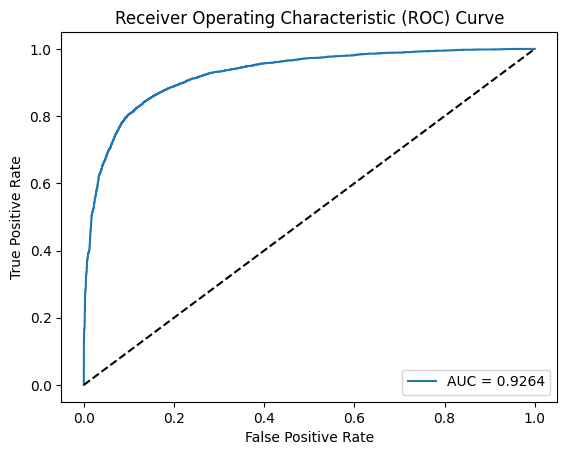

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Confusion matrix & classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

# --- ROC & AUC ---
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"\nROC AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(all_preds, all_probs)
# Example: maximize Youden’s J statistic (tpr - fpr)
best_idx = np.argmax(tpr - fpr)
thresholds[best_idx]


np.float32(0.50046116)

### 2.10. Generate Submission File

In this final step, the trained LSTM model is used to make predictions on the `test_loader` (unseen test data). The predicted `player_won` labels are then compiled into a pandas DataFrame along with their corresponding `battle_id`s and saved to `submission.csv`, ready for submission to the competition. The distribution of the predicted labels is also displayed.

In [ ]:
all_probs, all_preds = prediction(model, test_loader, test=True)

In [ ]:
pd.DataFrame([(index, label) for index, label in enumerate(all_preds)], columns=['battle_id','player_won']).to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame([(index, label) for index, label in enumerate(all_preds)], columns=['battle_id','player_won'])['player_won'].value_counts()

,count
player_won,
0,2661
1,2339
